In [1]:
SF = 10

In [2]:
from psutil import *
core=cpu_count()
core

2

# Install Package

In [3]:
!pip install databend
!pip install datafusion
!pip install duckdb  --upgrade
!pip install deltalake==0.17.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 MB 29.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 113.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 75.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: duckdb
    Found existing installation: duckdb 0.10.2
    Uninstalling duckdb-0.10.2:
      Successfully uninstalled duckdb-0.10.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 55.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: deltalake
    Found existing installation: deltalake 0.16.1
    Uninstalling deltalake-0.16.1:
      Successfully uninstalled deltalake-0.16.1


# Generate Delta

In [4]:
%%time
import duckdb
import pathlib
from deltalake import convert_to_deltalake
Table_Path = '/lakehouse/default/Tables'
Files_Path = '/lakehouse/default/Files'
if not pathlib.Path(f'{Table_Path}/CH{SF}').exists():
  if not pathlib.Path(f'{Files_Path}/tpch_{SF}.duckdb').exists():
    print('generate new database')
    pathlib.Path(f'{Files_Path}').mkdir(parents=True, exist_ok=True)
    con=duckdb.connect(f'{Files_Path}/tpch_{SF}.duckdb')
    con.sql(f"CALL dbgen(sf={SF}) ")
  else:
     con=duckdb.connect(f'{Files_Path}/tpch_{SF}.duckdb',read_only=1)
     print('DB exist')
  for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part']:
      pathlib.Path(f'{Table_Path}/CH{SF}/{tbl}').mkdir(parents=True, exist_ok=True)
      con.sql(f"""
      COPY (SELECT * FROM {tbl}) TO '{Table_Path}/CH{SF}/{tbl}' (FORMAT PARQUET,PER_THREAD_OUTPUT TRUE)
       """)
      convert_to_deltalake(f'{Table_Path}/CH{SF}/{tbl}',storage_options={"allow_unsafe_rename":"true"})
  con.close()
else:
  print("Already Generated")

Already Generated
CPU times: user 193 ms, sys: 37.1 ms, total: 230 ms
Wall time: 2.19 s


# SQL Query

In [5]:
# @title
sql=(f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;


SELECT
    --Query02
    s_acctbal,
    s_name,
    n_name,
    p_partkey,
    p_mfgr,
    s_address,
    s_phone,
    s_comment
FROM
    part,
    supplier,
    partsupp,
    nation,
    region
WHERE
    p_partkey = ps_partkey
    AND s_suppkey = ps_suppkey
    AND p_size = 15
    AND p_type LIKE '%BRASS'
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'EUROPE'
    AND ps_supplycost = (
        SELECT
            MIN(ps_supplycost)
        FROM
            partsupp,
            supplier,
            nation,
            region
        WHERE
            p_partkey = ps_partkey
            AND s_suppkey = ps_suppkey
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'EUROPE'
    )
ORDER BY
    s_acctbal DESC,
    n_name,
    s_name,
    p_partkey
LIMIT
    100;







SELECT
    --Query03
    l_orderkey,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    o_orderdate,
    o_shippriority
FROM
    customer,
    orders,
    lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < CAST('1995-03-15' AS date)
    AND l_shipdate > CAST('1995-03-15' AS date)
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue DESC,
    o_orderdate
LIMIT
    10;








SELECT
    --Query04
    o_orderpriority,
    COUNT(*) AS order_count
FROM
    orders
WHERE
    o_orderdate >= CAST('1993-07-01' AS date)
    AND o_orderdate < CAST('1993-10-01' AS date)
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem
        WHERE
            l_orderkey = o_orderkey
            AND l_commitdate < l_receiptdate
    )
GROUP BY
    o_orderpriority
ORDER BY
    o_orderpriority;








SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    customer,
    orders,
    lineitem,
    supplier,
    nation,
    region
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND l_suppkey = s_suppkey
    AND c_nationkey = s_nationkey
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'ASIA'
    AND o_orderdate >= CAST('1994-01-01' AS date)
    AND o_orderdate < CAST('1995-01-01' AS date)
GROUP BY
    n_name
ORDER BY
    revenue DESC;







SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;







SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM
    (
        SELECT
            n1.n_name AS supp_nation,
            n2.n_name AS cust_nation,
            EXTRACT(
                year
                FROM
                    l_shipdate
            ) AS l_year,
            l_extendedprice * (1 - l_discount) AS volume
        FROM
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2
        WHERE
            s_suppkey = l_suppkey
            AND o_orderkey = l_orderkey
            AND c_custkey = o_custkey
            AND s_nationkey = n1.n_nationkey
            AND c_nationkey = n2.n_nationkey
            AND (
                (
                    n1.n_name = 'FRANCE'
                    AND n2.n_name = 'GERMANY'
                )
                OR (
                    n1.n_name = 'GERMANY'
                    AND n2.n_name = 'FRANCE'
                )
            )
            AND l_shipdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
    ) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;







SELECT
    --Query08
    o_year,
    SUM(
        CASE
            WHEN nation = 'BRAZIL' THEN volume
            ELSE 0
        END
    ) / SUM(volume) AS mkt_share
FROM
    (
        SELECT
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) AS volume,
            n2.n_name AS nation
        FROM
            part,
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2,
            region
        WHERE
            p_partkey = l_partkey
            AND s_suppkey = l_suppkey
            AND l_orderkey = o_orderkey
            AND o_custkey = c_custkey
            AND c_nationkey = n1.n_nationkey
            AND n1.n_regionkey = r_regionkey
            AND r_name = 'AMERICA'
            AND s_nationkey = n2.n_nationkey
            AND o_orderdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
            AND p_type = 'ECONOMY ANODIZED STEEL'
    ) AS all_nations
GROUP BY
    o_year
ORDER BY
    o_year;










SELECT
    --Query09
    nation,
    o_year,
    SUM(amount) AS sum_profit
FROM
    (
        SELECT
            n_name AS nation,
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity AS amount
        FROM
            part,
            supplier,
            lineitem,
            partsupp,
            orders,
            nation
        WHERE
            s_suppkey = l_suppkey
            AND ps_suppkey = l_suppkey
            AND ps_partkey = l_partkey
            AND p_partkey = l_partkey
            AND o_orderkey = l_orderkey
            AND s_nationkey = n_nationkey
            AND p_name LIKE '%green%'
    ) AS profit
GROUP BY
    nation,
    o_year
ORDER BY
    nation,
    o_year DESC;








SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM
    customer,
    orders,
    lineitem,
    nation
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate >= CAST('1993-10-01' AS date)
    AND o_orderdate < CAST('1994-01-01' AS date)
    AND l_returnflag = 'R'
    AND c_nationkey = n_nationkey
GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    --Query11
    ps_partkey,
    SUM(ps_supplycost * ps_availqty) AS value
FROM
    partsupp,
    supplier,
    nation
WHERE
    ps_suppkey = s_suppkey
    AND s_nationkey = n_nationkey
    AND n_name = 'GERMANY'
GROUP BY
    ps_partkey
HAVING
    SUM(ps_supplycost * ps_availqty) > (
        SELECT
            SUM(ps_supplycost * ps_availqty) * (0.0001/{SF})
            -- SUM(ps_supplycost * ps_availqty) * 1
        FROM
            partsupp,
            supplier,
            nation
        WHERE
            ps_suppkey = s_suppkey
            AND s_nationkey = n_nationkey
            AND n_name = 'GERMANY'
    )
ORDER BY
    value DESC;








SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM
    orders,
    lineitem
WHERE
    o_orderkey = l_orderkey
    AND l_shipmode IN ('MAIL', 'SHIP')
    AND l_commitdate < l_receiptdate
    AND l_shipdate < l_commitdate
    AND l_receiptdate >= CAST('1994-01-01' AS date)
    AND l_receiptdate < CAST('1995-01-01' AS date)
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;








SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;








SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM
    lineitem,
    part
WHERE
    l_partkey = p_partkey
    AND l_shipdate >= date '1995-09-01'
    AND l_shipdate < CAST('1995-10-01' AS date);








SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            l_suppkey
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue1
    )
ORDER BY
    s_suppkey;








SELECT
    --Query16
    p_brand,
    p_type,
    p_size,
    COUNT(DISTINCT ps_suppkey) AS supplier_cnt
FROM
    partsupp,
    part
WHERE
    p_partkey = ps_partkey
    AND p_brand <> 'Brand#45'
    AND p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p_size IN (
        49,
        14,
        23,
        45,
        19,
        3,
        36,
        9
    )
    AND ps_suppkey NOT IN (
        SELECT
            s_suppkey
        FROM
            supplier
        WHERE
            s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p_brand,
    p_type,
    p_size
ORDER BY
    supplier_cnt DESC,
    p_brand,
    p_type,
    p_size;








SELECT
    --Query17
    SUM(l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem,
    part
WHERE
    p_partkey = l_partkey
    AND p_brand = 'Brand#23'
    AND p_container = 'MED BOX'
    AND l_quantity < (
        SELECT
            0.2 * AVG(l_quantity)
        FROM
            lineitem
        WHERE
            l_partkey = p_partkey
    );






SELECT
    --Query18
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice,
    SUM(l_quantity)
FROM
    customer,
    orders,
    lineitem
WHERE
    o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
    AND c_custkey = o_custkey
    AND o_orderkey = l_orderkey
GROUP BY
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice
ORDER BY
    o_totalprice DESC,
    o_orderdate
LIMIT
    100;





SELECT
    --Query19
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    lineitem,
    part
WHERE
    (
        p_partkey = l_partkey
        AND p_brand = 'Brand#12'
        AND p_container IN (
            'SM CASE',
            'SM BOX',
            'SM PACK',
            'SM PKG'
        )
        AND l_quantity >= 1
        AND l_quantity <= 1 + 10
        AND p_size BETWEEN 1
        AND 5
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#23'
        AND p_container IN (
            'MED BAG',
            'MED BOX',
            'MED PKG',
            'MED PACK'
        )
        AND l_quantity >= 10
        AND l_quantity <= 10 + 10
        AND p_size BETWEEN 1
        AND 10
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#34'
        AND p_container IN (
            'LG CASE',
            'LG BOX',
            'LG PACK',
            'LG PKG'
        )
        AND l_quantity >= 20
        AND l_quantity <= 20 + 10
        AND p_size BETWEEN 1
        AND 15
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    );






SELECT
    --Query20
    s_name,
    s_address
FROM
    supplier,
    nation
WHERE
    s_suppkey IN (
        SELECT
            ps_suppkey
        FROM
            partsupp
        WHERE
            ps_partkey IN (
                SELECT
                    p_partkey
                FROM
                    part
                WHERE
                    p_name LIKE 'forest%'
            )
            AND ps_availqty > (
                SELECT
                    0.5 * SUM(l_quantity)
                FROM
                    lineitem
                WHERE
                    l_partkey = ps_partkey
                    AND l_suppkey = ps_suppkey
                    AND l_shipdate >= CAST('1994-01-01' AS date)
                    AND l_shipdate < CAST('1995-01-01' AS date)
            )
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'CANADA'
ORDER BY
    s_name;






SELECT
    --Query21
    s_name,
    COUNT(*) AS numwait
FROM
    supplier,
    lineitem l1,
    orders,
    nation
WHERE
    s_suppkey = l1.l_suppkey
    AND o_orderkey = l1.l_orderkey
    AND o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem l2
        WHERE
            l2.l_orderkey = l1.l_orderkey
            AND l2.l_suppkey <> l1.l_suppkey
    )
    AND NOT EXISTS (
        SELECT
            *
        FROM
            lineitem l3
        WHERE
            l3.l_orderkey = l1.l_orderkey
            AND l3.l_suppkey <> l1.l_suppkey
            AND l3.l_receiptdate > l3.l_commitdate
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'SAUDI ARABIA'
GROUP BY
    s_name
ORDER BY
    numwait DESC,
    s_name
LIMIT
    100;






SELECT
    --Query22
    cntrycode,
    COUNT(*) AS numcust,
    SUM(c_acctbal) AS totacctbal
FROM
    (
        SELECT
            SUBSTRING(c_phone, 1, 2) AS cntrycode,
            c_acctbal
        FROM
            customer
        WHERE
            SUBSTRING(c_phone, 1, 2) IN (
                '13',
                '31',
                '23',
                '29',
                '30',
                '18',
                '17'
            )
            AND c_acctbal > (
                SELECT
                    AVG(c_acctbal)
                FROM
                    customer
                WHERE
                    c_acctbal > 0.00
                    AND SUBSTRING(c_phone, 1, 2) IN (
                        '13',
                        '31',
                        '23',
                        '29',
                        '30',
                        '18',
                        '17'
                    )
            )
            AND NOT EXISTS (
                SELECT
                    *
                FROM
                    orders
                WHERE
                    o_custkey = c_custkey
            )
    ) AS custsale
GROUP BY
    cntrycode
ORDER BY
    cntrycode;

''')

# Utility Function

In [6]:
%%time
import time
import pandas as pd
from deltalake.writer import write_deltalake
from datetime import datetime
pd.set_option('display.max_columns', 20)
def execute_query(engine, sql_script):
    df = pd.DataFrame(columns=['dur','query'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            try :
             engine.sql(value).show()
             stop = time.time()
             duration = stop-start
            except  Exception as er:
              print(er)
              duration = float('nan')
            print(duration)
            row = {'dur': duration,'query':index}
            df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
    return df

CPU times: user 490 µs, sys: 0 ns, total: 490 µs
Wall time: 478 µs


In [7]:
%%time
import duckdb
start = time.time()
con=duckdb.connect(f'/lakehouse/default/Files/tpch_{SF}.duckdb',read_only=True)
stop = time.time()
external_table_duration = stop-start
df=execute_query(con, sql)
df.at[0,'dur'] = df.at[0, 'dur'] + external_table_duration
df['Engine'] = 'duckdb_native'
df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['sf'] = SF
df['cpu'] = core
df['test'] = 'tpch'
write_deltalake('/lakehouse/default/Tables/dbo/result',df,mode="append",storage_options={"allow_unsafe_rename":"true"}) 

Query1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬──────────────┬───────────────┬───┬────────────────────┬─────────────────────┬─────────────┐
│ l_returnflag │ l_linestatus │    sum_qty    │ … │     avg_price      │      avg_disc       │ count_order │
│   varchar    │   varchar    │ decimal(38,2) │   │       double       │       double        │    int64    │
├──────────────┼──────────────┼───────────────┼───┼────────────────────┼─────────────────────┼─────────────┤
│ A            │ F            │  377518399.00 │ … │  38237.15100895854 │  0.0500065745402432 │    14804077 │
│ N            │ F            │    9851614.00 │ … │  38257.81066008114 │ 0.04997336773765667 │      385998 │
│ N            │ O            │  743124873.00 │ … │  38233.90292348181 │ 0.05000081182113131 │    29144351 │
│ R            │ F            │  377732830.00 │ … │ 38251.219273559764 │ 0.04999679231408742 │    14808183 │
├──────────────┴──────────────┴───────────────┴───┴────────────────────┴─────────────────────┴─────────────┤
│ 4 rows           

<timed exec>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬─────────────┬────────┬────────────────┐
│ supp_nation │ cust_nation │ l_year │    revenue     │
│   varchar   │   varchar   │ int64  │ decimal(38,4)  │
├─────────────┼─────────────┼────────┼────────────────┤
│ FRANCE      │ GERMANY     │   1995 │ 521960141.7003 │
│ FRANCE      │ GERMANY     │   1996 │ 524796110.3842 │
│ GERMANY     │ FRANCE      │   1995 │ 542199700.0546 │
│ GERMANY     │ FRANCE      │   1996 │ 533640926.2614 │
└─────────────┴─────────────┴────────┴────────────────┘

3.6918694972991943
Query8
┌────────┬─────────────────────┐
│ o_year │      mkt_share      │
│ int64  │       double        │
├────────┼─────────────────────┤
│   1995 │  0.0388201425143322 │
│   1996 │ 0.03948968749183992 │
└────────┴─────────────────────┘

1.2474400997161865
Query9


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬────────┬────────────────┐
│    nation     │ o_year │   sum_profit   │
│    varchar    │ int64  │ decimal(38,4)  │
├───────────────┼────────┼────────────────┤
│ ALGERIA       │   1998 │ 271504046.5508 │
│ ALGERIA       │   1997 │ 457035986.9555 │
│ ALGERIA       │   1996 │ 457125199.0414 │
│ ALGERIA       │   1995 │ 460972497.0491 │
│ ALGERIA       │   1994 │ 456444975.7127 │
│ ALGERIA       │   1993 │ 456449926.4138 │
│ ALGERIA       │   1992 │ 459548354.7680 │
│ ARGENTINA     │   1998 │ 277792984.9141 │
│ ARGENTINA     │   1997 │ 467555914.5594 │
│ ARGENTINA     │   1996 │ 473886192.7453 │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│ UNITED STATES │   1994 │ 476447816.2560 │
│ UNITED STATES │   1993 │ 460120427.2978 │
│ UNITED STATES │   1992 │ 468157792.3023 │
│ VIETNAM       │   1998 │ 272979518.3274 │
│ VIETNAM       │   1997 │ 473777590.7684 │
│ VIETNAM       │   1996 │ 46604

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────────┬───────────────┬───┬──────────────────────┬─────────────────┬──────────────────────┐
│ c_custkey │       c_name       │    revenue    │ … │      c_address       │     c_phone     │      c_comment       │
│   int64   │      varchar       │ decimal(38,4) │   │       varchar        │     varchar     │       varchar        │
├───────────┼────────────────────┼───────────────┼───┼──────────────────────┼─────────────────┼──────────────────────┤
│   1237537 │ Customer#001237537 │   884989.6657 │ … │ mdkU4LpZECCtt20RHa…  │ 32-367-120-4327 │ yly regular accoun…  │
│   1116802 │ Customer#001116802 │   830214.1117 │ … │ iBka7YijCCLApX1f 8…  │ 23-199-655-3770 │ y carefully regula…  │
│    508954 │ Customer#000508954 │   826167.5138 │ … │ tKQLmGq3MOqXiTmNZQRp │ 15-880-510-9487 │ t the quickly pend…  │
│   1487503 │ Customer#001487503 │   825996.5903 │ … │ D tOJIC0rcVO         │ 20-271-234-4401 │ ithely quiet depos…  │
│   1461247 │ Customer#001461247 │   775992.0820

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬──────────┐
│ c_count │ custdist │
│  int64  │  int64   │
├─────────┼──────────┤
│       0 │   500019 │
│      10 │    66125 │
│       9 │    65012 │
│      11 │    62192 │
│       8 │    58445 │
│      12 │    55784 │
│      13 │    49943 │
│      19 │    46595 │
│       7 │    46529 │
│      18 │    46036 │
│       · │       ·  │
│       · │       ·  │
│       · │       ·  │
│       1 │      232 │
│      36 │      144 │
│      37 │       83 │
│      38 │       47 │
│      39 │       16 │
│      40 │        9 │
│      41 │        7 │
│      42 │        4 │
│      43 │        3 │
│      46 │        1 │
├─────────┴──────────┤
│ 45 rows (20 shown) │
└────────────────────┘

3.049001932144165
Query14
┌────────────────────┐
│   promo_revenue    │
│       double       │
├────────────────────┤
│ 16.647594941615097 │
└────────────────────┘

0.7012996673583984
Query15
┌───────────┬────────────────────┬──────────────────────────────────────────┬─────────────────┬───────────────┐
│ s_s

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬───────────┬────────────┬─────────────┬───────────────┬─────────────────┐
│       c_name       │ c_custkey │ o_orderkey │ o_orderdate │ o_totalprice  │ sum(l_quantity) │
│      varchar       │   int64   │   int64    │    date     │ decimal(15,2) │  decimal(38,2)  │
├────────────────────┼───────────┼────────────┼─────────────┼───────────────┼─────────────────┤
│ Customer#001287812 │   1287812 │   42290181 │ 1997-11-26  │     558289.17 │          318.00 │
│ Customer#000644812 │    644812 │    2745894 │ 1996-07-04  │     557664.53 │          304.00 │
│ Customer#001172513 │   1172513 │   36667107 │ 1997-06-06  │     550142.18 │          322.00 │
│ Customer#000399481 │    399481 │   43906817 │ 1995-04-06  │     549431.65 │          312.00 │
│ Customer#000571654 │    571654 │   21213895 │ 1992-01-03  │     549380.08 │          327.00 │
│ Customer#000667882 │    667882 │    2199712 │ 1996-09-30  │     542154.01 │          327.00 │
│ Customer#001492954 │   1492954 │   303

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬─────────┐
│       s_name       │ numwait │
│      varchar       │  int64  │
├────────────────────┼─────────┤
│ Supplier#000062538 │      24 │
│ Supplier#000032858 │      22 │
│ Supplier#000063723 │      21 │
│ Supplier#000089484 │      21 │
│ Supplier#000007061 │      20 │
│ Supplier#000034162 │      20 │
│ Supplier#000086690 │      20 │
│ Supplier#000097808 │      20 │
│ Supplier#000004163 │      19 │
│ Supplier#000016074 │      19 │
│         ·          │       · │
│         ·          │       · │
│         ·          │       · │
│ Supplier#000099320 │      17 │
│ Supplier#000099325 │      17 │
│ Supplier#000000114 │      16 │
│ Supplier#000000821 │      16 │
│ Supplier#000004199 │      16 │
│ Supplier#000006757 │      16 │
│ Supplier#000006795 │      16 │
│ Supplier#000006824 │      16 │
│ Supplier#000007491 │      16 │
│ Supplier#000008301 │      16 │
├────────────────────┴─────────┤
│     100 rows (20 shown)      │
└──────────────────────────────┘

3.5345685

In [8]:
%%time
import duckdb
start = time.time()
for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
 duckdb.sql(f''' CREATE or replace View  {tbl} AS SELECT * FROM parquet_scan('/lakehouse/default/Tables/CH{SF}/{tbl}/*.parquet') ''')
stop = time.time()
external_table_duration = stop-start
df=execute_query(duckdb, sql)
df.at[0,'dur'] = df.at[0, 'dur'] + external_table_duration
df['Engine'] = 'duckdb'
df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['sf'] = SF
df['cpu'] = core
df['test'] = 'tpch'
write_deltalake('/lakehouse/default/Tables/dbo/result',df,mode="append",storage_options={"allow_unsafe_rename":"true"}) 

Query1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬──────────────┬───────────────┬───┬────────────────────┬─────────────────────┬─────────────┐
│ l_returnflag │ l_linestatus │    sum_qty    │ … │     avg_price      │      avg_disc       │ count_order │
│   varchar    │   varchar    │ decimal(38,2) │   │       double       │       double        │    int64    │
├──────────────┼──────────────┼───────────────┼───┼────────────────────┼─────────────────────┼─────────────┤
│ A            │ F            │  377518399.00 │ … │  38237.15100895854 │  0.0500065745402432 │    14804077 │
│ N            │ F            │    9851614.00 │ … │  38257.81066008114 │ 0.04997336773765667 │      385998 │
│ N            │ O            │  743124873.00 │ … │  38233.90292348181 │ 0.05000081182113131 │    29144351 │
│ R            │ F            │  377732830.00 │ … │ 38251.219273559764 │ 0.04999679231408742 │    14808183 │
├──────────────┴──────────────┴───────────────┴───┴────────────────────┴─────────────────────┴─────────────┤
│ 4 rows           

<timed exec>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬────────────────────┬────────────────┬───┬─────────────────┬──────────────────────┐
│   s_acctbal   │       s_name       │     n_name     │ … │     s_phone     │      s_comment       │
│ decimal(15,2) │      varchar       │    varchar     │   │     varchar     │       varchar        │
├───────────────┼────────────────────┼────────────────┼───┼─────────────────┼──────────────────────┤
│       9994.37 │ Supplier#000030084 │ GERMANY        │ … │ 17-519-171-6883 │ thely express inst…  │
│       9992.54 │ Supplier#000099650 │ RUSSIA         │ … │ 32-971-481-2533 │ ironic ideas. spec…  │
│       9987.51 │ Supplier#000020657 │ ROMANIA        │ … │ 29-167-460-7830 │  unusual requests …  │
│       9986.40 │ Supplier#000082995 │ RUSSIA         │ … │ 32-510-919-3096 │ e packages. slyly …  │
│       9984.69 │ Supplier#000008875 │ ROMANIA        │ … │ 29-132-904-4395 │  carefully. furiou…  │
│       9984.30 │ Supplier#000081977 │ RUSSIA         │ … │ 32-569-570-6149 │ , pending ins

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬───────────────┬─────────────┬────────────────┐
│ l_orderkey │    revenue    │ o_orderdate │ o_shippriority │
│   int64    │ decimal(38,4) │    date     │     int32      │
├────────────┼───────────────┼─────────────┼────────────────┤
│    4791171 │   440715.2185 │ 1995-02-23  │              0 │
│   46678469 │   439855.3250 │ 1995-01-27  │              0 │
│   23906758 │   432728.5737 │ 1995-03-14  │              0 │
│   23861382 │   428739.1368 │ 1995-03-09  │              0 │
│   59393639 │   426036.0662 │ 1995-02-12  │              0 │
│    3355202 │   425100.6657 │ 1995-03-04  │              0 │
│    9806272 │   425088.0568 │ 1995-03-13  │              0 │
│   22810436 │   423231.9690 │ 1995-01-02  │              0 │
│   16384100 │   421478.7294 │ 1995-03-02  │              0 │
│   52974151 │   415367.1195 │ 1995-02-05  │              0 │
├────────────┴───────────────┴─────────────┴────────────────┤
│ 10 rows                                         4 columns │
└───────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────┬─────────────┐
│ o_orderpriority │ order_count │
│     varchar     │    int64    │
├─────────────────┼─────────────┤
│ 1-URGENT        │      105214 │
│ 2-HIGH          │      104821 │
│ 3-MEDIUM        │      105227 │
│ 4-NOT SPECIFIED │      105422 │
│ 5-LOW           │      105356 │
└─────────────────┴─────────────┘

3.2539801597595215
Query5


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────┐
│  n_name   │    revenue     │
│  varchar  │ decimal(38,4)  │
├───────────┼────────────────┤
│ INDIA     │ 536862587.9995 │
│ CHINA     │ 535350829.9282 │
│ VIETNAM   │ 532269388.7176 │
│ JAPAN     │ 526766837.1444 │
│ INDONESIA │ 523176852.3189 │
└───────────┴────────────────┘

4.643354892730713
Query6


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────┐
│     revenue     │
│  decimal(38,4)  │
├─────────────────┤
│ 1230113636.0101 │
└─────────────────┘

3.624885082244873
Query7


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬─────────────┬────────┬────────────────┐
│ supp_nation │ cust_nation │ l_year │    revenue     │
│   varchar   │   varchar   │ int64  │ decimal(38,4)  │
├─────────────┼─────────────┼────────┼────────────────┤
│ FRANCE      │ GERMANY     │   1995 │ 521960141.7003 │
│ FRANCE      │ GERMANY     │   1996 │ 524796110.3842 │
│ GERMANY     │ FRANCE      │   1995 │ 542199700.0546 │
│ GERMANY     │ FRANCE      │   1996 │ 533640926.2614 │
└─────────────┴─────────────┴────────┴────────────────┘

11.694927215576172
Query8


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬─────────────────────┐
│ o_year │      mkt_share      │
│ int64  │       double        │
├────────┼─────────────────────┤
│   1995 │  0.0388201425143322 │
│   1996 │ 0.03948968749183992 │
└────────┴─────────────────────┘

5.99273419380188
Query9


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬────────┬────────────────┐
│    nation     │ o_year │   sum_profit   │
│    varchar    │ int64  │ decimal(38,4)  │
├───────────────┼────────┼────────────────┤
│ ALGERIA       │   1998 │ 271504046.5508 │
│ ALGERIA       │   1997 │ 457035986.9555 │
│ ALGERIA       │   1996 │ 457125199.0414 │
│ ALGERIA       │   1995 │ 460972497.0491 │
│ ALGERIA       │   1994 │ 456444975.7127 │
│ ALGERIA       │   1993 │ 456449926.4138 │
│ ALGERIA       │   1992 │ 459548354.7680 │
│ ARGENTINA     │   1998 │ 277792984.9141 │
│ ARGENTINA     │   1997 │ 467555914.5594 │
│ ARGENTINA     │   1996 │ 473886192.7453 │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│ UNITED STATES │   1994 │ 476447816.2560 │
│ UNITED STATES │   1993 │ 460120427.2978 │
│ UNITED STATES │   1992 │ 468157792.3023 │
│ VIETNAM       │   1998 │ 272979518.3274 │
│ VIETNAM       │   1997 │ 473777590.7684 │
│ VIETNAM       │   1996 │ 46604

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────────┬───────────────┬───┬──────────────────────┬─────────────────┬──────────────────────┐
│ c_custkey │       c_name       │    revenue    │ … │      c_address       │     c_phone     │      c_comment       │
│   int64   │      varchar       │ decimal(38,4) │   │       varchar        │     varchar     │       varchar        │
├───────────┼────────────────────┼───────────────┼───┼──────────────────────┼─────────────────┼──────────────────────┤
│   1237537 │ Customer#001237537 │   884989.6657 │ … │ mdkU4LpZECCtt20RHa…  │ 32-367-120-4327 │ yly regular accoun…  │
│   1116802 │ Customer#001116802 │   830214.1117 │ … │ iBka7YijCCLApX1f 8…  │ 23-199-655-3770 │ y carefully regula…  │
│    508954 │ Customer#000508954 │   826167.5138 │ … │ tKQLmGq3MOqXiTmNZQRp │ 15-880-510-9487 │ t the quickly pend…  │
│   1487503 │ Customer#001487503 │   825996.5903 │ … │ D tOJIC0rcVO         │ 20-271-234-4401 │ ithely quiet depos…  │
│   1461247 │ Customer#001461247 │   775992.0820

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬─────────────────┬────────────────┐
│ l_shipmode │ high_line_count │ low_line_count │
│  varchar   │     int128      │     int128     │
├────────────┼─────────────────┼────────────────┤
│ MAIL       │           62071 │          93045 │
│ SHIP       │           62426 │          93261 │
└────────────┴─────────────────┴────────────────┘

4.858482599258423
Query13


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬──────────┐
│ c_count │ custdist │
│  int64  │  int64   │
├─────────┼──────────┤
│       0 │   500019 │
│      10 │    66125 │
│       9 │    65012 │
│      11 │    62192 │
│       8 │    58445 │
│      12 │    55784 │
│      13 │    49943 │
│      19 │    46595 │
│       7 │    46529 │
│      18 │    46036 │
│       · │       ·  │
│       · │       ·  │
│       · │       ·  │
│       1 │      232 │
│      36 │      144 │
│      37 │       83 │
│      38 │       47 │
│      39 │       16 │
│      40 │        9 │
│      41 │        7 │
│      42 │        4 │
│      43 │        3 │
│      46 │        1 │
├─────────┴──────────┤
│ 45 rows (20 shown) │
└────────────────────┘

4.237486839294434
Query14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┐
│   promo_revenue    │
│       double       │
├────────────────────┤
│ 16.647594941615097 │
└────────────────────┘

3.621194362640381
Query15


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────────┬──────────────────────────────────────────┬─────────────────┬───────────────┐
│ s_suppkey │       s_name       │                s_address                 │     s_phone     │ total_revenue │
│   int64   │      varchar       │                 varchar                  │     varchar     │ decimal(38,4) │
├───────────┼────────────────────┼──────────────────────────────────────────┼─────────────────┼───────────────┤
│     69998 │ Supplier#000069998 │ 117W54YtKASNfzkZRS8P32856BMj0HKf895vdukw │ 16-386-278-9829 │  2194132.8166 │
└───────────┴────────────────────┴──────────────────────────────────────────┴─────────────────┴───────────────┘

6.932701587677002
Query16
┌──────────┬───────────────────────────┬────────┬──────────────┐
│ p_brand  │          p_type           │ p_size │ supplier_cnt │
│ varchar  │          varchar          │ int32  │    int64     │
├──────────┼───────────────────────────┼────────┼──────────────┤
│ Brand#44 │ STANDARD PLATED TIN       │ 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┐
│    avg_yearly     │
│      double       │
├───────────────────┤
│ 3295493.512857143 │
└───────────────────┘

4.9173264503479
Query18


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬───────────┬────────────┬─────────────┬───────────────┬─────────────────┐
│       c_name       │ c_custkey │ o_orderkey │ o_orderdate │ o_totalprice  │ sum(l_quantity) │
│      varchar       │   int64   │   int64    │    date     │ decimal(15,2) │  decimal(38,2)  │
├────────────────────┼───────────┼────────────┼─────────────┼───────────────┼─────────────────┤
│ Customer#001287812 │   1287812 │   42290181 │ 1997-11-26  │     558289.17 │          318.00 │
│ Customer#000644812 │    644812 │    2745894 │ 1996-07-04  │     557664.53 │          304.00 │
│ Customer#001172513 │   1172513 │   36667107 │ 1997-06-06  │     550142.18 │          322.00 │
│ Customer#000399481 │    399481 │   43906817 │ 1995-04-06  │     549431.65 │          312.00 │
│ Customer#000571654 │    571654 │   21213895 │ 1992-01-03  │     549380.08 │          327.00 │
│ Customer#000667882 │    667882 │    2199712 │ 1996-09-30  │     542154.01 │          327.00 │
│ Customer#001492954 │   1492954 │   303

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┐
│    revenue    │
│ decimal(38,4) │
├───────────────┤
│ 30104438.0911 │
└───────────────┘

6.323861837387085
Query20


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬────────────────────────────────────┐
│       s_name       │             s_address              │
│      varchar       │              varchar               │
├────────────────────┼────────────────────────────────────┤
│ Supplier#000000020 │ JtPqm19E7tF 152Rl1wQZ8j0H          │
│ Supplier#000000285 │ q TMZEDyZtv vUiFKBhT3NJlnIxpL      │
│ Supplier#000000358 │ 6XtuJkJj83BcCOV7bwV7wG5nkhazk      │
│ Supplier#000000361 │ MSi62aEN53KaoRAiaH4GEo3EsKMXSwpPGU │
│ Supplier#000000402 │ JR8vWoCteJtJg3okRpt0r28KEo         │
│ Supplier#000000555 │ 8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke      │
│ Supplier#000000688 │ orLvVDOBBE2B2ppjbiTZTJoIJgn1VgKg3  │
│ Supplier#000000729 │ CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI │
│ Supplier#000000744 │ WdgxvW4WEloeapP7H6cWHrGLCHkStwrM   │
│ Supplier#000000752 │ GrOjezmDCNvHXl5                    │
│         ·          │        ·                           │
│         ·          │        ·                           │
│         ·          │        ·         

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬─────────┐
│       s_name       │ numwait │
│      varchar       │  int64  │
├────────────────────┼─────────┤
│ Supplier#000062538 │      24 │
│ Supplier#000032858 │      22 │
│ Supplier#000063723 │      21 │
│ Supplier#000089484 │      21 │
│ Supplier#000007061 │      20 │
│ Supplier#000034162 │      20 │
│ Supplier#000086690 │      20 │
│ Supplier#000097808 │      20 │
│ Supplier#000004163 │      19 │
│ Supplier#000016074 │      19 │
│         ·          │       · │
│         ·          │       · │
│         ·          │       · │
│ Supplier#000099320 │      17 │
│ Supplier#000099325 │      17 │
│ Supplier#000000114 │      16 │
│ Supplier#000000821 │      16 │
│ Supplier#000004199 │      16 │
│ Supplier#000006757 │      16 │
│ Supplier#000006795 │      16 │
│ Supplier#000006824 │      16 │
│ Supplier#000007491 │      16 │
│ Supplier#000008301 │      16 │
├────────────────────┴─────────┤
│     100 rows (20 shown)      │
└──────────────────────────────┘

23.320290

In [9]:
%%time
from datafusion import SessionContext
start = time.time()
ctx = SessionContext()
for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
 ctx.register_parquet(f'{tbl}',  f'/lakehouse/default/Tables/CH{SF}/{tbl}/*.parquet')
stop = time.time()
external_table_duration = stop-start
df = execute_query(ctx,sql)
df.at[0,'dur'] = df.at[0, 'dur'] + external_table_duration
df['Engine'] = 'datafusion'
df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['sf'] = SF
df['cpu'] = core
df['test'] = 'tpch'
write_deltalake('/lakehouse/default/Tables/dbo/result',df,mode="append",storage_options={"allow_unsafe_rename":"true"}) 

Query1
DataFrame()
+--------------+--------------+--------------+------------------+--------------------+----------------------+-----------+--------------+----------+-------------+
| l_returnflag | l_linestatus | sum_qty      | sum_base_price   | sum_disc_price     | sum_charge           | avg_qty   | avg_price    | avg_disc | count_order |
+--------------+--------------+--------------+------------------+--------------------+----------------------+-----------+--------------+----------+-------------+
| A            | F            | 377518399.00 | 566065727797.25  | 537759104278.0656  | 559276670892.116819  | 25.500975 | 38237.151008 | 0.050006 | 14804077    |
| N            | F            | 9851614.00   | 14767438399.17   | 14028805792.2114   | 14590490998.366737   | 25.522448 | 38257.810660 | 0.049973 | 385998      |
| N            | O            | 743124873.00 | 1114302286901.88 | 1058580922144.9638 | 1100937000170.591854 | 25.498075 | 38233.902923 | 0.050000 | 29144351    |
| R      

<timed exec>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [10]:
%%time
from databend import SessionContext
start = time.time()
ctx_bend = SessionContext("TPCH")
for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
    ctx_bend.sql(f"""CREATE or replace view {tbl} AS SELECT * FROM 'fs:///lakehouse/default/Tables/CH{SF}/{tbl}/' (pattern => '.*.parquet' ) """).collect()
stop = time.time()
external_table_duration = stop-start
df = execute_query(ctx_bend, sql)
df.at[0,'dur'] = df.at[0, 'dur'] + external_table_duration
df['Engine'] = 'databend'
df['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df['sf'] = SF
df['cpu'] = core
df['test'] = 'tpch'
write_deltalake('/lakehouse/default/Tables/dbo/result',df,mode="append",storage_options={"allow_unsafe_rename":"true"}) 

Query1
┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ l_returnflag │ l_linestatus │       sum_qty       │    sum_base_price   │    sum_disc_price   │      sum_charge      │       avg_qty       │      avg_price      │       avg_disc      │ count_order │
│  String NULL │  String NULL │ Decimal(38, 2) NULL │ Decimal(38, 2) NULL │ Decimal(38, 4) NULL │  Decimal(38, 6) NULL │ Decimal(38, 8) NULL │ Decimal(38, 8) NULL │ Decimal(38, 8) NULL │    UInt64   │
├──────────────┼──────────────┼─────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┼─────────────────────┼─────────────────────┼─────────────────────┼─────────────┤
│ 'A'          │ 'F'          │ 377518399.00        │ 566065727797.25     │ 537759104278.0656   │ 559276670892.116819  │ 25.50097510         │ 38237.15100896      │ 0.05000657          │   

<timed exec>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


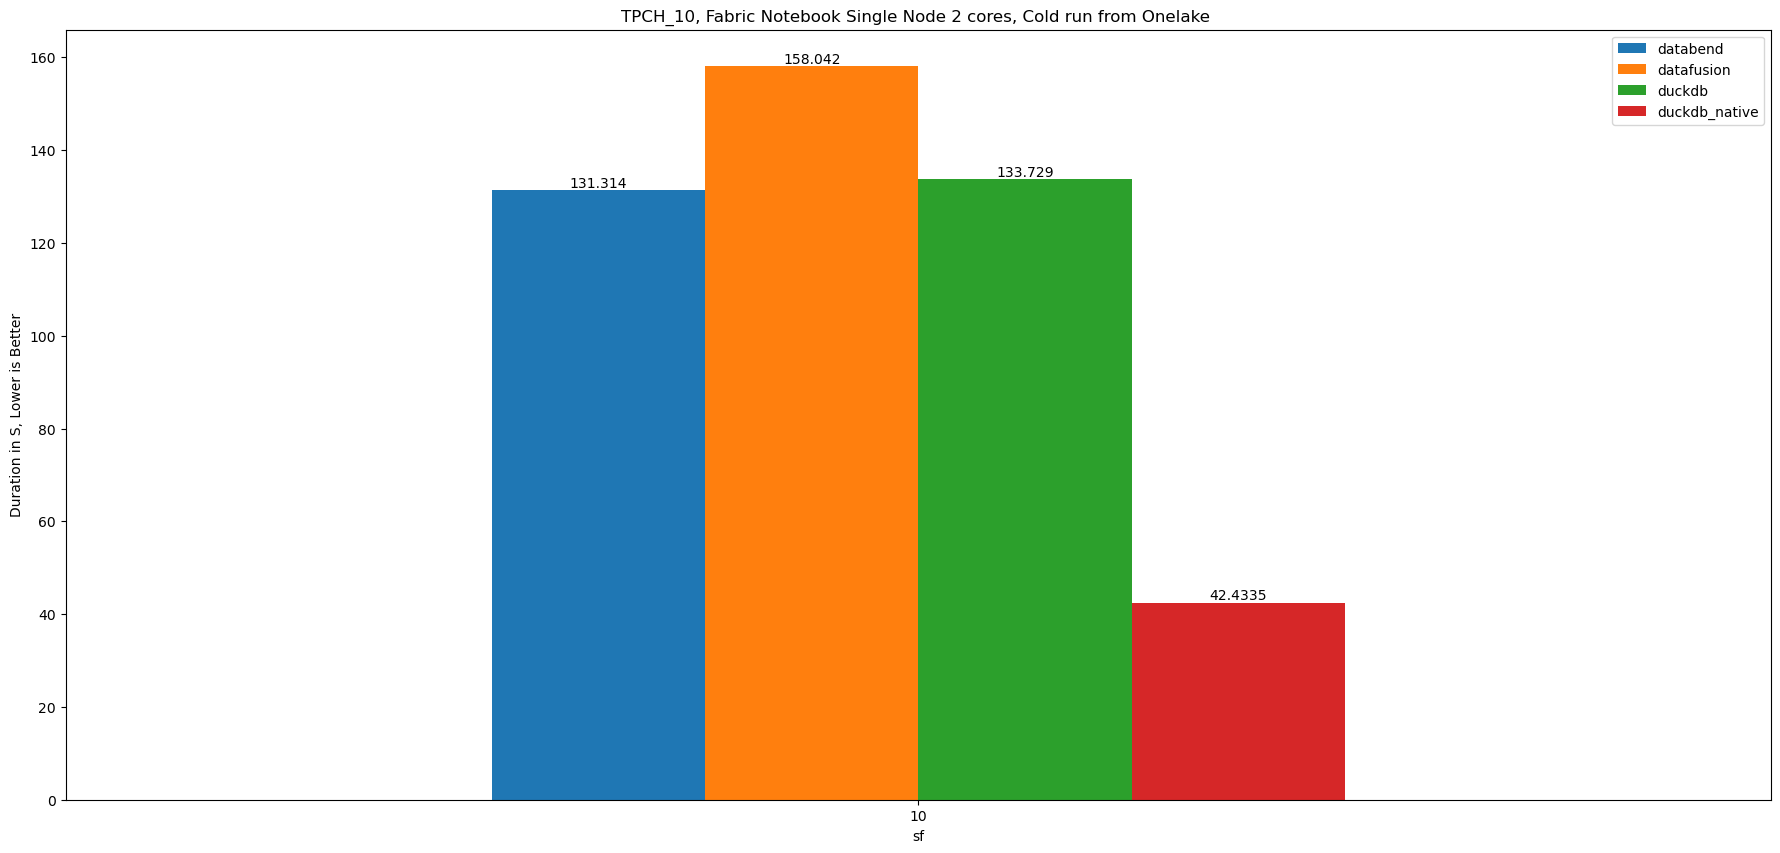

In [11]:
import duckdb
pv = duckdb.sql(f"""PIVOT ( select Engine,sf, dur, query from delta_scan('/lakehouse/default/Tables/dbo/result' ) where sf = {SF} and test  ='tpch') ON Engine using avg(dur) order by query""")
xx = duckdb.sql(f" select sf, sum(COLUMNS(*exclude(sf,query))) from pv  group by all order by sf  ").df()
ax = xx.plot.bar(rot=0,x='sf',title=f"TPCH_{SF}, Fabric Notebook Single Node {core} cores, Cold run from Onelake ",ylabel='Duration in S, Lower is Better',figsize=(22,10))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')